            Category  Count
0          Bird-drop    193
1              Clean    194
2              Dusty    191
3  Electrical-damage    104
4    Physical-Damage     70
5       Snow-Covered    124


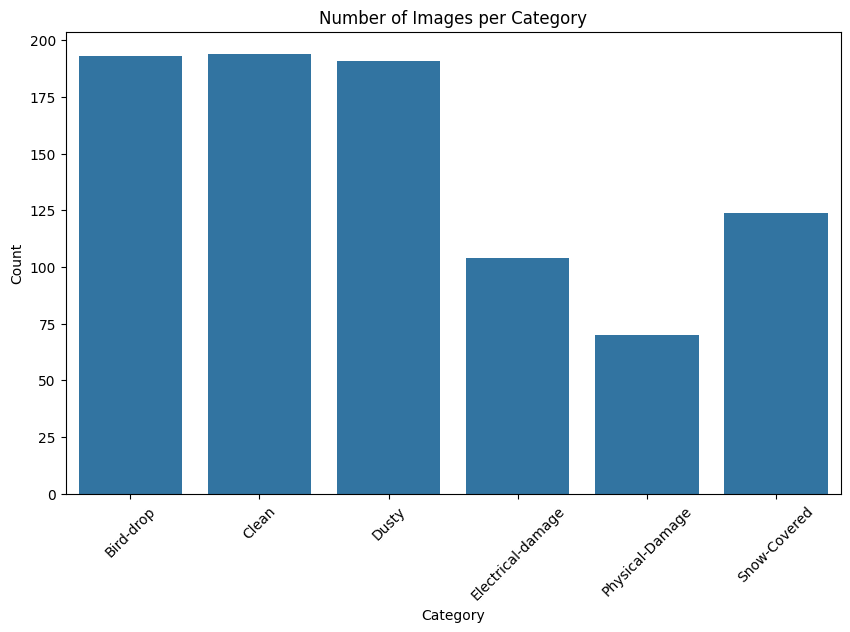

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the path to your dataset
dataset_path = '../dataset/'

# Get the list of categories (folder names)
categories = os.listdir(dataset_path)

# Count images in each category
image_counts = {}
for category in categories:
    path = os.path.join(dataset_path, category)
    if os.path.isdir(path):
        image_counts[category] = len(os.listdir(path))

# Create a DataFrame for easy plotting
df_counts = pd.DataFrame(list(image_counts.items()), columns=['Category', 'Count'])
print(df_counts)

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Count', data=df_counts)
plt.title('Number of Images per Category')
plt.xticks(rotation=45)
plt.show()

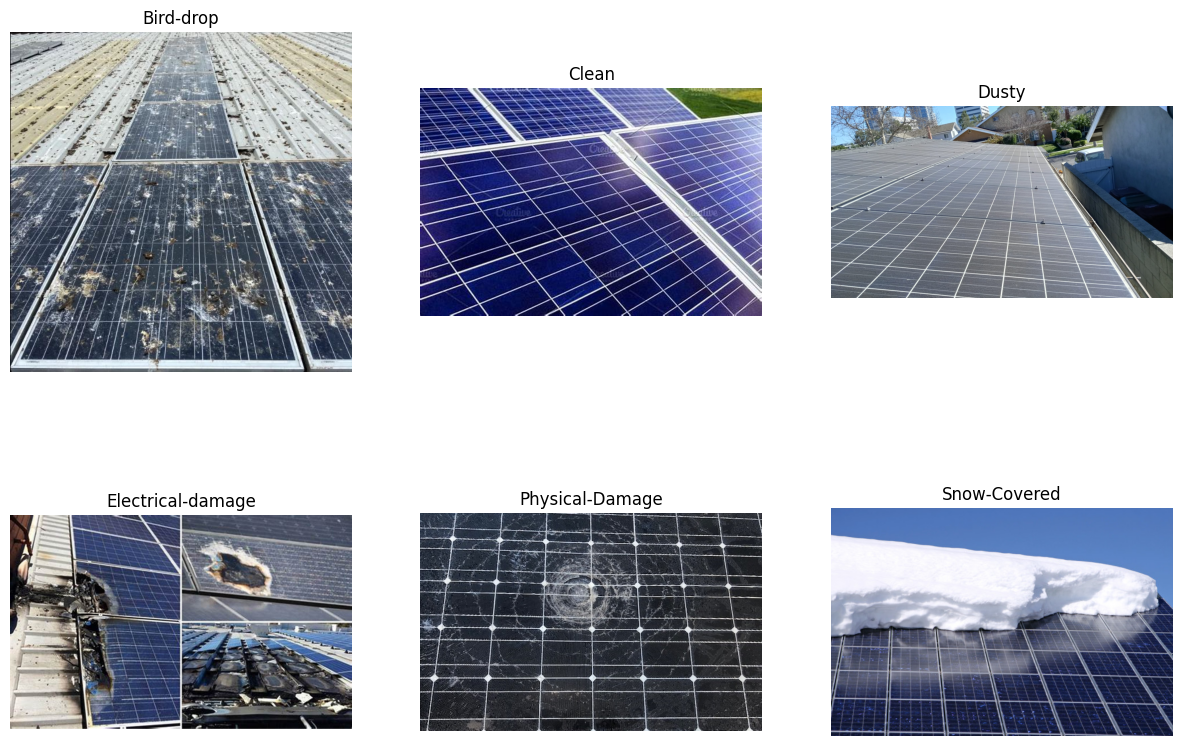

In [2]:
import random
from PIL import Image

plt.figure(figsize=(15, 10))

for i, category in enumerate(categories):
    path = os.path.join(dataset_path, category)
    if os.path.isdir(path):
        # Get a random image from the directory
        random_image_name = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_image_name)

        # Open and display the image
        plt.subplot(2, 3, i + 1) # We have 6 categories, so 2 rows, 3 columns
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')

plt.show()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image parameters
IMAGE_SIZE = (224, 224) # A common size for many pre-trained models
BATCH_SIZE = 32         # How many images the model looks at in one go

# 1. Create a generator for the training data (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values from 0-255 to 0-1 [cite: 46, 64]
    rotation_range=20,          # Randomly rotate images
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    horizontal_flip=True,       # Randomly flip images horizontally [cite: 43]
    zoom_range=0.2,             # Randomly zoom in on images
    validation_split=0.2        # Set aside 20% of the data for validation
)

# 2. Create a generator for the validation data (NO augmentation)
# The validation set must be a true representation of the original data.
validation_datagen = ImageDataGenerator(
    rescale=1./255,             # Only normalize the pixel values 
    validation_split=0.2        # Use the same 20% split
)

# 3. Create the actual generators from our directories
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',   # For multi-class classification
    subset='training'           # Specify this is the training set
)

validation_generator = validation_datagen.flow_from_directory(
    dataset_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'         # Specify this is the validation set
)

# Check the results
print(f"Classes found: {list(train_generator.class_indices.keys())}")
print(f"Number of training images: {train_generator.samples}")
print(f"Number of validation images: {validation_generator.samples}")


Found 711 images belonging to 6 classes.
Found 174 images belonging to 6 classes.
Classes found: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
Number of training images: 711
Number of validation images: 174


In [4]:
# THIS IS THE NEW CODE TO USE

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam # We will use Adam optimizer with a lower learning rate

# 1. Load the base model (same as before)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# We will first freeze the base model and train our new layers
base_model.trainable = False

# 2. Add our custom layers (same as before)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# 3. First Stage Compilation & Training
# We compile and train for a few epochs with the base model frozen
print("--- STAGE 1: TRAINING TOP LAYERS ---")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_top = model.fit(train_generator, epochs=5, validation_data=validation_generator)


# 4. FINE-TUNING STAGE
print("\n--- STAGE 2: FINE-TUNING ---")
# Now, we un-freeze the base model
base_model.trainable = True

# Let's un-freeze from the 100th layer onwards.
# The earlier layers detect very basic features (lines, colors), we don't need to change them.
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# 5. Re-compile the model with a very low learning rate
# This is crucial for fine-tuning. We want to make very small adjustments.
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Continue training (fine-tuning)
# We train for more epochs on top of the initial training.
fine_tune_epochs = 15
total_epochs = 5 + fine_tune_epochs

# Combine the history from both stages
# NOTE: The variable 'history' is now created here.
history = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history_top.epoch[-1], # Start from where we left off
    validation_data=validation_generator
)

# Append the initial history to the fine-tuning history for plotting
for key in history_top.history:
    history.history[key] = history_top.history[key] + history.history[key]

# Now, you can run your evaluation and plotting cells as before!
# And don't forget to save the newly trained model.
model.save('../saved_model/solar_panel_model_finetuned.h5')
print("Fine-tuned model saved successfully!")



--- STAGE 1: TRAINING TOP LAYERS ---

Epoch 1/5


23/23 [==============================] - 45s 2s/step - loss: 1.9905 - accuracy: 0.4613 - val_loss: 0.9902 - val_accuracy: 0.6379
Epoch 2/5
23/23 [==============================] - 39s 2s/step - loss: 0.8840 - accuracy: 0.6793 - val_loss: 0.8017 - val_accuracy: 0.6667
Epoch 3/5
23/23 [==============================] - 37s 2s/step - loss: 0.6618 - accuracy: 0.7722 - val_loss: 0.7112 - val_accuracy: 0.7299
Epoch 4/5
23/23 [==============================] - 37s 2s/step - loss: 0.5602 - accuracy: 0.8073 - val_loss: 0.7174 - val_accuracy: 0.7414
Epoch 5/5
23/23 [==============================] - 37s 2s/step - loss: 0.5200 - accuracy: 0.8143 - val_loss: 0.5993 - val_accuracy: 0.7874

--- STAGE 2: FINE-TUNING ---
Epoch 5/20
23/23 [==============================] - 53s 2s/step - loss: 1.3427 - accuracy: 0.5288 - val_loss: 0.6588 - val_accuracy: 0.7586
Epoch 6/20
23/23 [==============================] - 39s 2s/step - loss: 1.0299 - accuracy: 0.

C:\Users\jerwi\Desktop\guvi aiml\SolarGuard_Project\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fine-tuned model saved successfully!


In [5]:
# Define the number of epochs
EPOCHS = 10

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

Epoch 1/10
23/23 [==============================] - 39s 2s/step - loss: 0.4428 - accuracy: 0.8397 - val_loss: 0.8297 - val_accuracy: 0.7356
Epoch 2/10
23/23 [==============================] - 39s 2s/step - loss: 0.4772 - accuracy: 0.8467 - val_loss: 0.8087 - val_accuracy: 0.7356
Epoch 3/10
23/23 [==============================] - 39s 2s/step - loss: 0.3960 - accuracy: 0.8706 - val_loss: 0.8039 - val_accuracy: 0.7414
Epoch 4/10
23/23 [==============================] - 39s 2s/step - loss: 0.4275 - accuracy: 0.8537 - val_loss: 0.8181 - val_accuracy: 0.7414
Epoch 5/10
23/23 [==============================] - 39s 2s/step - loss: 0.3901 - accuracy: 0.8720 - val_loss: 0.8058 - val_accuracy: 0.7356
Epoch 6/10
23/23 [==============================] - 39s 2s/step - loss: 0.3782 - accuracy: 0.8762 - val_loss: 0.7889 - val_accuracy: 0.7356
Epoch 7/10
23/23 [==============================] - 40s 2s/step - loss: 0.3807 - accuracy: 0.8734 - val_loss: 0.7773 - val_accuracy: 0.7356
Epoch 8/10
23/23 [==

In [6]:
# THIS IS THE NEW AND FINAL TRAINING CODE

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.utils import class_weight

# --- Step 1: Calculate Class Weights ---
# This is the new part that addresses the data imbalance.
print("--- CALCULATING CLASS WEIGHTS ---")
# Get the class indices from the training generator
class_indices = train_generator.class_indices
# Create a mapping from index to class name
class_names = list(class_indices.keys())
# Get the class labels for all training samples
class_labels = train_generator.classes

# Calculate the weights
weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
# Create a dictionary mapping class index to its weight
class_weights = dict(zip(np.unique(class_labels), weights))
print("Calculated Class Weights:")
for i, class_name in enumerate(class_names):
    print(f"  - {class_name}: {class_weights[i]:.2f}")


# --- Step 2: Build the Model (same as before) ---
print("\n--- BUILDING THE MODEL ---")
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# --- Step 3: First Stage Training ---
print("\n--- STAGE 1: TRAINING TOP LAYERS ---")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_top = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    class_weight=class_weights # <-- We are now using the calculated weights!
)

# --- Step 4: Fine-Tuning Stage ---
print("\n--- STAGE 2: FINE-TUNING ---")
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Let's train for a bit longer in the fine-tuning stage
fine_tune_epochs = 20 # Increased from 15 to 20
total_epochs = 5 + fine_tune_epochs

history = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history_top.epoch[-1],
    validation_data=validation_generator,
    class_weight=class_weights # <-- Using weights in fine-tuning as well!
)

# --- Step 5: Combine History and Save ---
for key in history_top.history:
    history.history[key] = history_top.history[key] + history.history[key]

model.save('../saved_model/solar_panel_model_final.h5')
print("\nFinal model saved successfully!")

--- CALCULATING CLASS WEIGHTS ---
Calculated Class Weights:
  - Bird-drop: 0.71
  - Clean: 0.76
  - Dusty: 0.78
  - Electrical-damage: 1.43
  - Physical-Damage: 2.12
  - Snow-Covered: 1.20

--- BUILDING THE MODEL ---

--- STAGE 1: TRAINING TOP LAYERS ---
Epoch 1/5
23/23 [==============================] - 44s 2s/step - loss: 1.5480 - accuracy: 0.4416 - val_loss: 0.7210 - val_accuracy: 0.7184
Epoch 2/5
23/23 [==============================] - 36s 2s/step - loss: 0.7880 - accuracy: 0.7004 - val_loss: 0.6808 - val_accuracy: 0.7241
Epoch 3/5
23/23 [==============================] - 37s 2s/step - loss: 0.6362 - accuracy: 0.7567 - val_loss: 0.7721 - val_accuracy: 0.7241
Epoch 4/5
23/23 [==============================] - 37s 2s/step - loss: 0.5899 - accuracy: 0.7567 - val_loss: 0.5398 - val_accuracy: 0.8218
Epoch 5/5
23/23 [==============================] - 38s 2s/step - loss: 0.4993 - accuracy: 0.7975 - val_loss: 0.5781 - val_accuracy: 0.8161

--- STAGE 2: FINE-TUNING ---
Epoch 5/25
23/23 [==

C:\Users\jerwi\Desktop\guvi aiml\SolarGuard_Project\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Final model saved successfully!


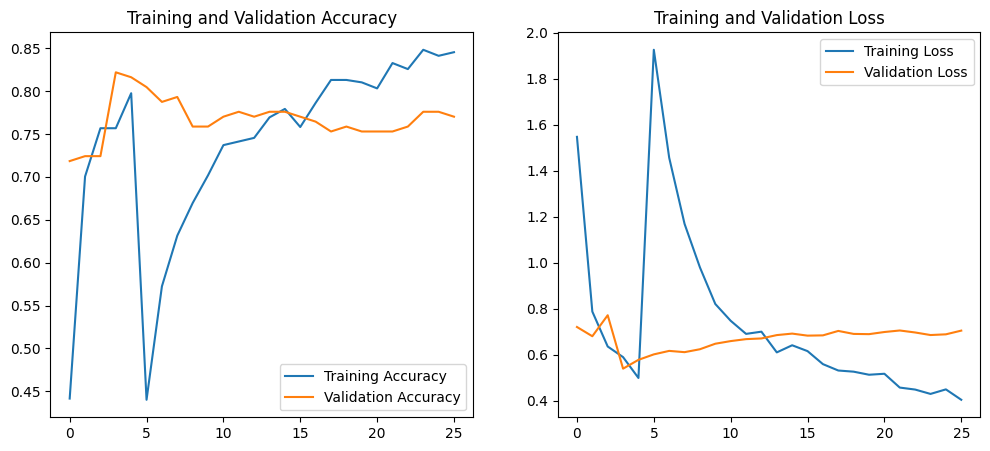

In [8]:
# THIS IS THE CORRECTED PLOTTING CODE

# The history object now contains the combined history from both training stages.
# Let's get the metrics from it.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# *** THE FIX IS HERE ***
# Instead of a fixed range, we get the number of epochs directly from the history object.
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

6/6 [==============================] - 8s 1s/step

Classification Report:

                   precision    recall  f1-score   support

        Bird-drop       0.20      0.20      0.20        41
            Clean       0.26      0.42      0.32        38
            Dusty       0.11      0.08      0.09        38
Electrical-damage       0.23      0.15      0.18        20
  Physical-Damage       0.08      0.08      0.08        13
     Snow-Covered       0.05      0.04      0.05        24

         accuracy                           0.18       174
        macro avg       0.15      0.16      0.15       174
     weighted avg       0.17      0.18      0.17       174


Confusion Matrix:



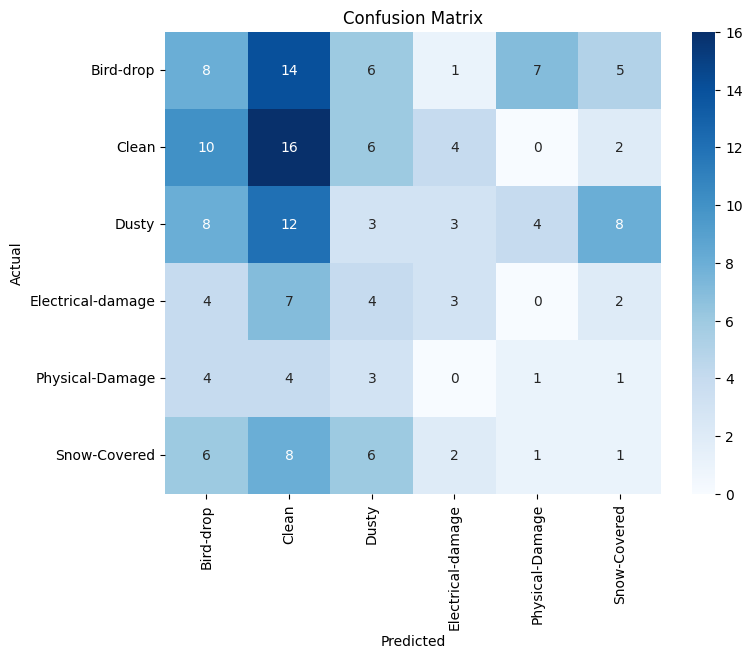

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get the true labels and predicted labels for the validation set
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

# Get the class labels
class_labels = list(validation_generator.class_indices.keys())

# 1. Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 2. Confusion Matrix
print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()